# Importing the packages needed

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import scipy
from scipy.sparse import csr_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

# Loading data

In [2]:
# importing data
df = pd.read_csv('winemag-data-130k-v2.csv', index_col = 0)

## Performing descriptive analytics

In [3]:
df.dtypes

country                   object
description               object
designation               object
points                     int64
price                    float64
province                  object
region_1                  object
region_2                  object
taster_name               object
taster_twitter_handle     object
title                     object
variety                   object
winery                    object
dtype: object

In [4]:
df.describe()

,points,price
count,129971.000000,120975.000000
mean,88.447138,35.363389
std,3.039730,41.022218
min,80.000000,4.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,3300.000000


[Text(0.5, 0, '% missing value'),
 Text(0, 0.5, 'variable'),
 Text(0.5, 1.0, 'Missing values percentage')]

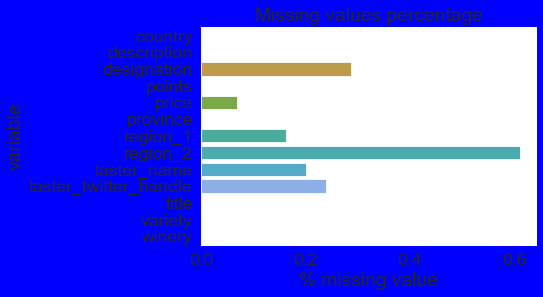

In [5]:
sns.set(rc = {'axes.facecolor':'white', 'figure.facecolor':'blue'})
sns.set_context('paper', font_scale = 2)
x = sns.barplot(x = np.array(df.isnull().sum())/df.shape[0], y = df.columns.tolist())
x.set(xlabel = '% missing value', ylabel = 'variable', title = 'Missing values percentage')

## Cleaning the data

In [6]:
df = df.drop(columns = ['region_2', 'designation', 'taster_twitter_handle'])
df = df.dropna()
df.head()

,country,description,points,price,province,region_1,taster_name,title,variety,winery
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Willamette Valley,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,Spain,Blackberry and raspberry aromas show a typical...,87,15.0,Northern Spain,Navarra,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem
6,Italy,"Here's a bright, informal red that opens with ...",87,16.0,Sicily & Sardinia,Vittoria,Kerin O’Keefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo


## Dividing points into 4 grade buckets as the response variable
##### Grade 1: 96~100
##### Grade 2: 91~95
##### Grade 3: 86~90
##### Grade 4: 80~85

In [7]:
df['dummy'] = (100 - df['points'])/5
df['dummy'] = df['dummy'].astype(int)
df['grades'] = df['dummy'] + 1

for i in range(len(df['grades'])):
    if df['grades'].iloc[i] == 5:
        df['grades'].iloc[i] = 4

df = df.drop(columns = ['dummy'])
df.head()

C:\Users\smirn\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,country,description,points,price,province,region_1,taster_name,title,variety,winery,grades
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Willamette Valley,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,3
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,3
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,3
5,Spain,Blackberry and raspberry aromas show a typical...,87,15.0,Northern Spain,Navarra,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,3
6,Italy,"Here's a bright, informal red that opens with ...",87,16.0,Sicily & Sardinia,Vittoria,Kerin O’Keefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo,3


## Combining description, province, and region_1 for bundle analysis in Model 2

In [8]:
df['bundle'] = df['description'] + df['province'] + " " + df['region_1']

## Use pd.get_dummies to code the columns country, province, region_1, winery, and variety

In [9]:
df1 = df.drop(columns = ['points', 'price', 'taster_name', 'title', 'grades'])
df1 = pd.get_dummies(df1, columns = ['country', 'province', 'variety', 'region_1', 'winery'], drop_first = True,
                     sparse = True)

## Spliting the dataset into training and testing sets

In [10]:
X = df1
y = df['grades']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

In [11]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

## The null model

[Text(0.5, 0, 'grades'),
 Text(0, 0.5, '% percentage counts'),
 Text(0.5, 1.0, '% counts of grades')]

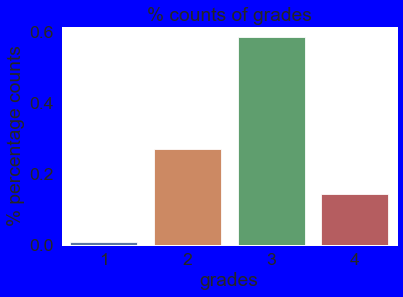

In [12]:
x = sns.barplot(x = np.unique(df["grades"]), y = np.array(df.groupby(['grades']).size()/df.shape[0]))
x.set(xlabel = 'grades', ylabel = '% percentage counts', title = '% counts of grades')

In [13]:
df['grades'].value_counts(normalize = True)

3    0.583380
2    0.269274
4    0.140888
1    0.006458
Name: grades, dtype: float64

# Model 1 (Using description to predict grades)

## Vectorizing description

In [14]:
cv = CountVectorizer(stop_words = 'english')
X_train_1 = cv.fit_transform(X_train['description'])
X_test_1 = cv.transform(X_test['description'])

## Hyperparameter tuning using pipeline

In [15]:
pipe = Pipeline([('classifier', MultinomialNB())])

search_space = [{'classifier': [MultinomialNB()],
                 'classifier__alpha': [0.01, 0.1, 1, 10]}]

clf = GridSearchCV(pipe, search_space, cv = 10, verbose = 0)

best_model = clf.fit(X_train_1, y_train)

In [16]:
best_model.best_estimator_.get_params()['classifier']
best_model.best_params_

{'classifier': MultinomialNB(alpha=1), 'classifier__alpha': 1}

## Error rates of the model

In [17]:
print(f"Best model mean validation error = {1 - best_model.best_score_:.2f}")
print(f"Best model training error = {1 - best_model.score(X_train_1, y_train):.2f}")
print(f"Best model testing error = {1 - best_model.score(X_test_1, y_test):.2f}")

Best model mean validation error = 0.31
Best model training error = 0.27
Best model testing error = 0.31


# Model 2 (Using description, province, and region_1 to predict grades)

## Vectorizing bundle

In [18]:
X_train_2 = cv.fit_transform(X_train['bundle'])
X_test_2 = cv.transform(X_test['bundle'])

## Hyperparameter tuning using pipeline

In [19]:
pipe = Pipeline([('classifier', MultinomialNB())])

search_space = [{'classifier': [MultinomialNB()],
                 'classifier__alpha': [0.01, 0.1, 1, 10]}]

clf = GridSearchCV(pipe, search_space, cv = 10, verbose = 0)

best_model = clf.fit(X_train_2, y_train)

In [20]:
best_model.best_estimator_.get_params()['classifier']
best_model.best_params_

{'classifier': MultinomialNB(alpha=1), 'classifier__alpha': 1}

## Error rates of the model

In [21]:
print(f"Best model mean validation error = {1 - best_model.best_score_:.2f}")
print(f"Best model training error = {1 - best_model.score(X_train_2, y_train):.2f}")
print(f"Best model testing error = {1 - best_model.score(X_test_2, y_test):.2f}")

Best model mean validation error = 0.31
Best model training error = 0.27
Best model testing error = 0.31


# Model 3 (Using country, province, region_1, winery, and variety to predict grades)

## Transforming the encoded variables into sparse matrix

In [22]:
X_train_3 = scipy.sparse.csr_matrix(X_train.drop(columns = ['description', 'bundle']).values)
X_test_3 = scipy.sparse.csr_matrix(X_test.drop(columns = ['description', 'bundle']).values)

## Hyperparameter tuning using pipeline

In [23]:
pipe = Pipeline([('classifier', MultinomialNB())])

search_space = [{'classifier': [MultinomialNB()],
                 'classifier__alpha': [0.01, 0.1, 1, 10]},
               {'classifier': [DecisionTreeClassifier()],
               'classifier__max_depth': [1, 5, 10, 15, 20]},
               {'classifier': [LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg')],
                 'classifier__C': [0.01, 0.1, 1.0]}]

clf = GridSearchCV(pipe, search_space, cv = 10, verbose = 0)

best_model = clf.fit(X_train_3, y_train)

In [24]:
best_model.best_estimator_.get_params()['classifier']
best_model.best_params_

{'classifier': LogisticRegression(multi_class='multinomial', solver='newton-cg'),
 'classifier__C': 1.0}

## Error rates of the model

In [25]:
print(f"Best model mean validation error = {1 - best_model.best_score_:.2f}")
print(f"Best model training error = {1 - best_model.score(X_train_3, y_train):.2f}")
print(f"Best model testing error = {1 - best_model.score(X_test_3, y_test):.2f}")

Best model mean validation error = 0.32
Best model training error = 0.25
Best model testing error = 0.32


## Confusion Matrix for Logistic model

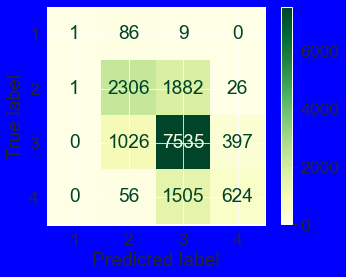

In [26]:
plot_confusion_matrix(best_model, X_test_3, y_test, cmap = 'YlGn', values_format = '.0f')

## Finding out the 10 items with the highest coefficients

In [27]:
model = LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg',C = 1.0).fit(X_train_3, y_train)

In [28]:
beta_coef = pd.DataFrame({'names': X_train.drop(columns = ['description', 'bundle']).columns[0:],
              'coefs': (abs(pd.DataFrame(model.coef_)).sum())}).sort_values(by = 'coefs', ascending = False)

In [29]:
beta_coef[0:10]

,names,coefs
11470,winery_Schramsberg,6.650860
13185,winery_Williams Selyem,6.523971
1353,region_1_Saint-Julien,6.350113
642,region_1_Bourgogne,6.062570
3495,winery_Cayuse,6.029238
1879,winery_Alpha Omega,6.026014
10889,winery_Quilceda Creek,5.994515
8419,winery_Ken Wright,5.839398
6332,winery_Domaine Zind-Humbrecht,5.635263
2480,winery_Betz Family,5.609781


# Model 4 (Using winery to predict grades)

## Transforming the encoded variables into sparse matrix

In [30]:
X_train_4 = scipy.sparse.csr_matrix(X_train.filter(regex = 'winery').values)
X_test_4 = scipy.sparse.csr_matrix(X_test.filter(regex = 'winery').values)

## Hyperparameter tuning using pipeline

In [31]:
pipe = Pipeline([('classifier', MultinomialNB())])

search_space = [{'classifier': [MultinomialNB()],
                 'classifier__alpha': [0.01, 0.1, 1, 10]},
               {'classifier': [DecisionTreeClassifier()],
               'classifier__max_depth': [1, 5, 10, 15, 20]},
               {'classifier': [LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg')],
                 'classifier__C': [0.01, 0.1, 1.0]}]

clf = GridSearchCV(pipe, search_space, cv = 10, verbose = 0)

best_model = clf.fit(X_train_4, y_train)

In [32]:
best_model.best_estimator_.get_params()['classifier']
best_model.best_params_

{'classifier': MultinomialNB(alpha=0.1), 'classifier__alpha': 0.1}

## Error rates of the model

In [33]:
print(f"Best model mean validation error = {1 - best_model.best_score_:.2f}")
print(f"Best model training error = {1 - best_model.score(X_train_4, y_train):.2f}")
print(f"Best model testing error = {1 - best_model.score(X_test_4, y_test):.2f}")

Best model mean validation error = 0.35
Best model training error = 0.27
Best model testing error = 0.35
